# Why your trading strategy doesn't work!

<b> YouTube Tutorial </b> (Published: Feb 10, 2022): https://youtu.be/_j5HP2wrBPE

The Perils of Multiple Testing - p-hacking during backtesting.

Here we use the example of a classic Simple Moving Average Crossover strategy, using Backtrader in Python. https://www.backtrader.com/home/helloalgotrading/

In [ ]:
## This is required for pandas_datareader on google colab - then you need to restart runtime
!pip install --upgrade pandas_datareader

## pip install backtrader
!pip install backtrader

     |████████████████████████████████| 410 kB 4.9 MB/s 


In [ ]:
import datetime
import time
import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import backtrader as bt
from itertools import product

In [ ]:
# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    return stockData

stockList = ['AAPL']
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=2000)

stockData = get_data(stockList[0], startDate, endDate)
stockData = stockData.sort_values(by="Date")
len(stockData)

stockData_IS = stockData[:int(len(stockData)*0.75)]
stockData_OS = stockData[-int(len(stockData)*0.25):]

print(len(stockData), len(stockData_IS), len(stockData_OS))

actualStart = stockData.index[0]

data = bt.feeds.PandasData(dataname=stockData_IS)

stockData_IS

1378 1033 344


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-08-25,26.969999,26.670000,26.847500,26.892500,100344800.0,25.152077
2016-08-26,26.987499,26.577499,26.852501,26.735001,111065200.0,25.004766
2016-08-29,26.860001,26.572500,26.655001,26.705000,99881200.0,24.976711
2016-08-30,26.625000,26.375000,26.450001,26.500000,99455600.0,24.784985
2016-08-31,26.642500,26.410000,26.415001,26.525000,118649600.0,24.808359
...,...,...,...,...,...,...
2020-09-25,112.440002,107.669998,108.430000,112.279999,149981400.0,111.258110
2020-09-28,115.320000,112.779999,115.010002,114.959999,137672400.0,113.913734
2020-09-29,115.309998,113.570000,114.550003,114.089996,99382200.0,113.051643


## Separate data into two sections: In Sample and Out of Sample

In [ ]:
print('IS DATA: starting ', stockData_IS.index[0],' finshing ', stockData_IS.index[-1])
print('OS DATA: starting ', stockData_OS.index[0],' finshing ', stockData_OS.index[-1])

IS DATA: starting  2016-08-25 00:00:00  finshing  2020-10-01 00:00:00
OS DATA: starting  2020-10-05 00:00:00  finshing  2022-02-14 00:00:00


## Strategy Class to define the indicators and logic of Moving Average cross over strat

In [ ]:
class MAcrossover(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=20   # period for the slow moving average
    )

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
#         print(f'{dt.isoformat()} {txt}') # Comment this line when running optimization

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


## Fixed commission Scheme
 - unrealistic (but will do for now)
 - hard to implement correctly with changes in risk sizer

In [ ]:
class FixedCommisionScheme(bt.CommInfoBase):
    paras = (
        ('commission', 10),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED)
    )

    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

## Risk sizer with risk parameter (% of capital)

In [ ]:
class maxRiskSizer(bt.Sizer):
    '''
    Returns the number of shares rounded down that can be purchased for the
    max rish tolerance
    '''
        # list of parameters which are configurable for the strategy
    params = dict(
        prisk=0.35
    )

    def __init__(self):
        if self.p.prisk > 1 or self.p.prisk < 0:
            raise ValueError('The risk parameter is a percentage which must be'
                'entered as a float. e.g. 0.5')

    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy == True:
            size = math.floor((cash * self.p.prisk) / data[0])
        else:
            size = math.floor((cash * self.p.prisk) / data[0]) * -1
        return size

In [ ]:
optimized_runs = {}

In [ ]:
def run(data, params, graph=False, benchmark=False):
    #Add Data
    cerebro = bt.Cerebro()
    cerebro.adddata(data)

    #Analyzers
    cerebro.addanalyzer(bt.analyzers.AnnualReturn)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe_ratio')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

    # Broker Information
    broker_args = dict(coc=True)
    cerebro.broker = bt.brokers.BackBroker(**broker_args)
    comminfo = FixedCommisionScheme()
    cerebro.broker.addcommissioninfo(comminfo)
    cerebro.broker.set_cash(10000)

    # Add Strategy
    if benchmark:
        cerebro.addstrategy(BuyAndHold)
    else:
        cerebro.addstrategy(MAcrossover, pfast=params[0],pslow=params[1])

        #Default position size
        cerebro.addsizer(maxRiskSizer, prisk=params[2])

    strats = cerebro.run()
    if graph:
        cerebro.plot(iplot=False, style='candlestick')
    return strats

## List of parameter permutations

In [ ]:
pfast=range(5,25,5)
pslow=range(50,110,10)
prisk=np.linspace(0.1,1,9)

params = list(product(pfast, pslow, prisk))
# params

## Let the scenarios (multiple tests) rip

In [ ]:
start = time.time()
for param in params:
    print(param)
    optimized_runs[param] = run(data, param)
end = time.time()
print('  time taken {:.2f} s'.format(end-start))

(5, 50, 0.1)
(5, 50, 0.21250000000000002)
(5, 50, 0.325)
(5, 50, 0.4375)
(5, 50, 0.55)
(5, 50, 0.6625)
(5, 50, 0.775)
(5, 50, 0.8875)
(5, 50, 1.0)
(5, 60, 0.1)
(5, 60, 0.21250000000000002)
(5, 60, 0.325)
(5, 60, 0.4375)
(5, 60, 0.55)
(5, 60, 0.6625)
(5, 60, 0.775)
(5, 60, 0.8875)
(5, 60, 1.0)
(5, 70, 0.1)
(5, 70, 0.21250000000000002)
(5, 70, 0.325)
(5, 70, 0.4375)
(5, 70, 0.55)
(5, 70, 0.6625)
(5, 70, 0.775)
(5, 70, 0.8875)
(5, 70, 1.0)
(5, 80, 0.1)
(5, 80, 0.21250000000000002)
(5, 80, 0.325)
(5, 80, 0.4375)
(5, 80, 0.55)
(5, 80, 0.6625)
(5, 80, 0.775)
(5, 80, 0.8875)
(5, 80, 1.0)
(5, 90, 0.1)
(5, 90, 0.21250000000000002)
(5, 90, 0.325)
(5, 90, 0.4375)
(5, 90, 0.55)
(5, 90, 0.6625)
(5, 90, 0.775)
(5, 90, 0.8875)
(5, 90, 1.0)
(5, 100, 0.1)
(5, 100, 0.21250000000000002)
(5, 100, 0.325)
(5, 100, 0.4375)
(5, 100, 0.55)
(5, 100, 0.6625)
(5, 100, 0.775)
(5, 100, 0.8875)
(5, 100, 1.0)
(10, 50, 0.1)
(10, 50, 0.21250000000000002)
(10, 50, 0.325)
(10, 50, 0.4375)
(10, 50, 0.55)
(10, 50, 0.6625)


In [ ]:
final_results_list = []
for runs in optimized_runs:
    for strategy in optimized_runs[runs]:
        PnL = round(strategy.broker.get_value() - 10000,2)
        sharpe = strategy.analyzers.sharpe_ratio.get_analysis()
        final_results_list.append([strategy.params.pfast,
            strategy.params.pslow, round(runs[2],1), PnL, round(sharpe['sharperatio'],2)])

sort_by_sharpe = sorted(final_results_list, key=lambda x: x[3],
                         reverse=True)

sort_by_sharpe = sorted(sort_by_sharpe, key=lambda x: x[4],
                         reverse=True)
for line in sort_by_sharpe[:5]:
    print(line)

len(optimized_runs)

[5, 50, 1.0, 26709.84, 1.23]
[5, 50, 0.9, 22357.27, 1.23]
[5, 50, 0.8, 18379.23, 1.23]
[5, 50, 0.7, 14812.17, 1.23]
[5, 50, 0.6, 11523.43, 1.22]


216

## In Sample Test

Test historical walk-forward 'optimised' parameter combination

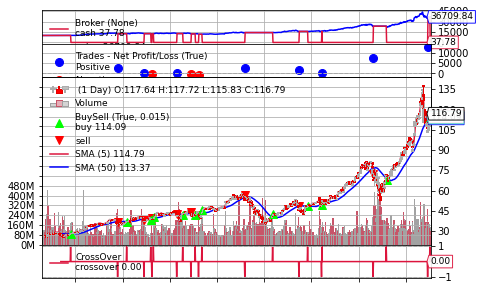

In [ ]:
strats = run(data,(5,50,1), graph=True)

In [ ]:
strat_0 = strats[0]
portfolio_stats = strat_0.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
vol = np.std(returns)*np.sqrt(252)
returns.index = returns.index.tz_convert(None)
PnL = round(strat_0.broker.get_value() - 10000,2)

sharpe = strat_0.analyzers.sharpe_ratio.get_analysis()

print('PnL $                  : ',round(PnL,2))
print('Sharpe Ratio           : ',round(sharpe['sharperatio'],2))
print('Annualised Volatility %: ', round(vol*100,2))

PnL $                  :  26709.84
Sharpe Ratio           :  1.23
Annualised Volatility %:  20.54


## Complete hypothesis test

- null hypothesis: there is no difference between our result and a portfolio with a 0 sharpe ratio

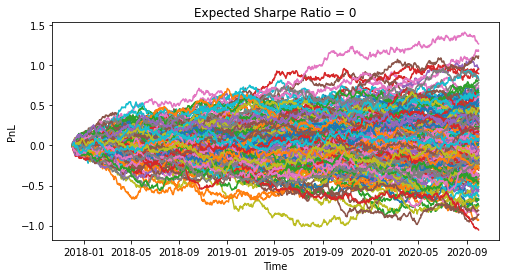

In [ ]:
fig = plt.figure(figsize=(8,4))
sharperatios=np.random.normal(0, vol*np.sqrt(1/252), (len(stockData_IS), 200))
dates=pd.date_range(end = stockData_IS.index[-1], periods = len(stockData_IS)).to_pydatetime().tolist()
plt.plot(dates, np.cumsum(sharperatios,axis=0))
plt.xlabel('Time')
plt.ylabel('PnL')
plt.title('Expected Sharpe Ratio = 0')
plt.show()

$\large T-statistic = Sharpe Ratio \times \sqrt{\# Years}$

$\large T-statistic = 1.23 \times \sqrt{\frac{1033}{252}}$

$\large T-statistic = 2.5$

In [ ]:
t_statistic = 1.23*np.sqrt(1033/252)
t_statistic

2.490319113229123

In [ ]:
t_statistic = sharpe['sharperatio']*np.sqrt(len(stockData_IS)/252)
print('Our T-statistic: ',round(t_statistic,2))
print('p_value ', round(stats.t.pdf(t_statistic,999),3))
print('T_crit at 5% CI', round(stats.t.ppf(1-0.05,999),3))

Our T-statistic:  2.49
p_value  0.018
T_crit at 5% CI 1.646


## Out of Sample Test

Test historical walk-forward 'optimised' parameter combination

In [ ]:
data_OS = bt.feeds.PandasData(dataname=stockData_OS)

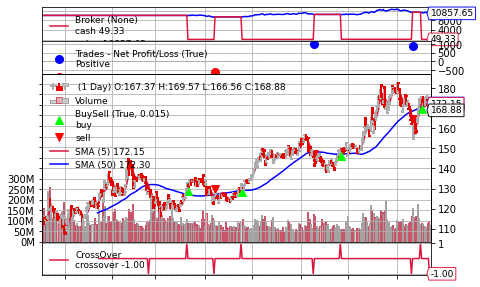

In [ ]:
strats = run(data_OS,(5,50,1), graph=True)

In [ ]:
strat_0 = strats[0]
portfolio_stats = strat_0.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
vol = np.std(returns)*np.sqrt(252)
returns.index = returns.index.tz_convert(None)
PnL = round(strat_0.broker.get_value() - 10000,2)

sharpe = strat_0.analyzers.sharpe_ratio.get_analysis()

print('PnL $                  : ',round(PnL,2))
print('Sharpe Ratio           : ',round(sharpe['sharperatio'],2))
print('Annualised Volatility %: ', round(vol*100,2))

PnL $                  :  857.65
Sharpe Ratio           :  0.19
Annualised Volatility %:  15.63


## Why does this strategy vastly underperform

Maybe it's not a true strategy and we made a false discovery.

You need to account for **multiple testing**, when we 'optimised' the parameters we ran 216 tests.

In [ ]:
print('T_crit at adjusted Bonferroni t-stat', round(stats.t.ppf(1-0.05/216,999),3))

T_crit at adjusted Bonferroni t-stat 3.513




> Hence we would not reject the null hypothesis when considering multiple testing!


> Without considering multiple testing under a framework like the Bonferroni method we would lead to a higher rate of false discoveries



